# 4-5 Advantage Actor Critic (A2C)

In [1]:
#TensorFlowがGPUを認識しているか確認
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-11-24 14:45:06.165409: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-11-24 14:45:06.206828: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-11-24 14:45:06.211349: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560a577eef60 executing computations on platform Host. Devices:
2022-11-24 14:45:06.211374: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-11-24 14:45:06.213291: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2022-11-24 14:45:06.618855: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560a59b3d570 executing computations on platform CUDA. Devices:
2022-11-24 14:45:06.618888: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Tesla V100-PC

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5847636411644546285,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17314364496554502713
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13801906824802298310
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11070226894451675079
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10655573977658148663
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3768294989851588831
 physical_device_desc: "device: XLA_GPU device"

In [2]:
import argparse
from collections import deque
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.python import keras as K
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import gym
import gym_ple
import sys
sys.path.append("../FN")
from fn_framework import FNAgent, Trainer, Observer
tf.compat.v1.disable_eager_execution()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


code 4-24 agent定義

In [3]:
class ActorCriticAgent(FNAgent):

    def __init__(self, actions):
        # ActorCriticAgent uses self policy (doesn't use epsilon).
        super().__init__(epsilon=0.0, actions=actions)
        self._updater = None

    @classmethod
    def load(cls, env, model_path):
        actions = list(range(env.action_space.n))
        agent = cls(actions)
        agent.model = K.models.load_model(model_path, custom_objects={
                        "SampleLayer": SampleLayer})
        agent.initialized = True
        return agent

    def initialize(self, experiences, optimizer):
        feature_shape = experiences[0].s.shape
        self.make_model(feature_shape)
        self.set_updater(optimizer)
        self.initialized = True
        print("Done initialization. From now, begin training!")

    def make_model(self, feature_shape):
        normal = K.initializers.glorot_normal()
        model = K.Sequential()
        model.add(K.layers.Conv2D(
            32, kernel_size=8, strides=4, padding="same",
            input_shape=feature_shape,
            kernel_initializer=normal, activation="relu"))
        model.add(K.layers.Conv2D(
            64, kernel_size=4, strides=2, padding="same",
            kernel_initializer=normal, activation="relu"))
        model.add(K.layers.Conv2D(
            64, kernel_size=3, strides=1, padding="same",
            kernel_initializer=normal, activation="relu"))
        model.add(K.layers.Flatten())
        model.add(K.layers.Dense(256, kernel_initializer=normal,
                                 activation="relu"))
        # -------- ここまではactorもcriticも共用 --------
        # actor layer: Q(s, a)を出力し、後述のsample layerで行動を価値に基づいてsampling
        actor_layer = K.layers.Dense(len(self.actions),
                                     kernel_initializer=normal)
        action_evals = actor_layer(model.output)
        actions = SampleLayer()(action_evals)
        # critic layer: 状態のみの価値 V(s) を出力する
        critic_layer = K.layers.Dense(1, kernel_initializer=normal)
        values = critic_layer(model.output)

        self.model = K.Model(inputs=model.input,
                             outputs=[actions, action_evals, values])

    def set_updater(self, optimizer,
                    value_loss_weight=1.0, entropy_weight=0.1):
        actions = tf.compat.v1.placeholder(shape=(None), dtype="int32")
        values = tf.compat.v1.placeholder(shape=(None), dtype="float32")

        _, action_evals, estimateds = self.model.output
        
        # -log pi (a|s) 
        neg_logs = tf.nn.sparse_softmax_cross_entropy_with_logits(
                        logits=action_evals, labels=actions)
        # tf.stop_gradient: Prevent policy_loss influences critic_layer.
        advantages = values - tf.stop_gradient(estimateds)

        # policy loss -> actor layer側のloss
        # value loss -> critic layer側のloss
        policy_loss = tf.reduce_mean(neg_logs * advantages)
        value_loss = tf.keras.losses.MeanSquaredError()(values, estimateds)
        # 過学習を防ぐ措置
        action_entropy = tf.reduce_mean(self.categorical_entropy(action_evals))

        loss = policy_loss + value_loss_weight * value_loss
        loss -= entropy_weight * action_entropy

        updates = optimizer.get_updates(loss=loss,
                                        params=self.model.trainable_weights)

        self._updater = K.backend.function(
                                        inputs=[self.model.input,
                                                actions, values],
                                        outputs=[loss,
                                                 policy_loss,
                                                 value_loss,
                                                 tf.reduce_mean(neg_logs),
                                                 tf.reduce_mean(advantages),
                                                 action_entropy],
                                        updates=updates)

    def categorical_entropy(self, logits):
        """
        From OpenAI baseline implementation.
        https://github.com/openai/baselines/blob/master/baselines/common/distributions.py#L192
        """
        a0 = logits - tf.reduce_max(logits, axis=-1, keepdims=True)
        ea0 = tf.exp(a0)
        z0 = tf.reduce_sum(ea0, axis=-1, keepdims=True)
        p0 = ea0 / z0
        return tf.reduce_sum(p0 * (tf.math.log(z0) - a0), axis=-1)

    def policy(self, s):
        """モデルから行動を出力"""
        if not self.initialized:
            return np.random.randint(len(self.actions))
        else:
            action, action_evals, values = self.model.predict(np.array([s]))
            return action[0]

    def estimate(self, s):
        """モデルから状態価値V(s)を出力"""
        action, action_evals, values = self.model.predict(np.array([s]))
        return values[0][0]

    def update(self, states, actions, rewards):
        return self._updater([states, actions, rewards])
    
    # jupyter labで描画させるためにoverlap
    def play(self, env, episode_count=1, render=True):
        action_dic = {0: "neutral", 1: "right", 2: "left"}
        for e in range(episode_count):
            s = env.reset()
            done = False
            episode_reward = 0
            cnt = 0
            get_num = 0
            play_num = 1
            while not done:
                # 毎回レンダリングすると遅くなるので最初の50回は毎回レンダリングし、その後は50回おきにする
                if render and (cnt <= 50):
                    env.render()
                elif render and (cnt % 50 == 0):
                    env.render()
                a = self.policy(s)
                n_state, reward, done, info = env.step(a)
                plt.title(f"episode={e}, action={action_dic[a]}, done={done}, frame={cnt}")
                episode_reward += reward
                s = n_state
                cnt += 1
            else:
                print("Get reward {}.".format(episode_reward))

code 4-26 学習モデルから行動を選択する

In [4]:
class SampleLayer(K.layers.Layer):

    def __init__(self, **kwargs):
        self.output_dim = 1  # sample one action from evaluations
        super(SampleLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SampleLayer, self).build(input_shape)

    def call(self, x):
        """Gaumbel Max Trick
        サンプリングの際にノイズを乗せて、行動をバラつかせる
        """
        noise = tf.random.uniform(tf.shape(x))
        return tf.argmax(x - tf.math.log(-tf.math.log(noise)), axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


code 4-27 価値関数の実装でも行ったテスト用Agentの作成

In [5]:
class ActorCriticAgentTest(ActorCriticAgent):

    def make_model(self, feature_shape):
        normal = K.initializers.glorot_normal()
        model = K.Sequential()
        model.add(K.layers.Dense(10, input_shape=feature_shape,
                                 kernel_initializer=normal, activation="relu"))
        model.add(K.layers.Dense(10, kernel_initializer=normal,
                                 activation="relu"))

        actor_layer = K.layers.Dense(len(self.actions),
                                     kernel_initializer=normal)

        action_evals = actor_layer(model.output)
        actions = SampleLayer()(action_evals)

        critic_layer = K.layers.Dense(1, kernel_initializer=normal)
        values = critic_layer(model.output)

        self.model = K.Model(inputs=model.input,
                             outputs=[actions, action_evals, values])

code 4-28 observer定義

In [6]:
class CatcherObserver(Observer):

    def __init__(self, env, width, height, frame_count):
        super().__init__(env)
        self.width = width
        self.height = height
        self.frame_count = frame_count
        self._frames = deque(maxlen=frame_count)

    def transform(self, state):
        grayed = Image.fromarray(state).convert("L")
        resized = grayed.resize((self.width, self.height))
        resized = np.array(resized).astype("float")
        normalized = resized / 255.0  # scale to 0~1
        if len(self._frames) == 0:
            for i in range(self.frame_count):
                self._frames.append(normalized)
        else:
            self._frames.append(normalized)
        feature = np.array(self._frames)
        # Convert the feature shape (f, w, h) => (h, w, f).
        feature = np.transpose(feature, (1, 2, 0))
        return feature
    
    # jupyter labで描画させるためにoverlap
    def render(self):
        # self._env.render(mode="rgb_array")
        plt.imshow(self._env.render(mode="rgb_array"))
        display.display(plt.gcf())
        display.clear_output(wait=True)


code 4-29 Trainer定義

In [7]:
class ActorCriticTrainer(Trainer):

    def __init__(self, buffer_size=256, batch_size=32,
                 gamma=0.99, learning_rate=1e-3,
                 report_interval=10, log_dir="", file_name=""):
        super().__init__(buffer_size, batch_size, gamma,
                         report_interval, log_dir)
        self.file_name = file_name if file_name else "a2c_agent.h5"
        self.learning_rate = learning_rate
        self.losses = {}
        self.rewards = []
        self._max_reward = -10

    def train(self, env, episode_count=900, initial_count=10,
              test_mode=False, render=False, observe_interval=100):
        actions = list(range(env.action_space.n))
        if not test_mode:
            agent = ActorCriticAgent(actions)
        else:
            agent = ActorCriticAgentTest(actions)
            observe_interval = 0
        self.training_episode = episode_count

        self.train_loop(env, agent, episode_count, initial_count, render,
                        observe_interval)
        return agent

    def episode_begin(self, episode, agent):
        self.rewards = []

    def step(self, episode, step_count, agent, experience):
        self.rewards.append(experience.r)
        if not agent.initialized:
            if len(self.experiences) < self.buffer_size:
                # Store experience until buffer_size (enough to initialize).
                return False

            optimizer = K.optimizers.Adam(lr=self.learning_rate,
                                          clipnorm=5.0)
            agent.initialize(self.experiences, optimizer)
            self.logger.set_model(agent.model)
            self.training = True
            self.experiences.clear()
        else:
            if len(self.experiences) < self.batch_size:
                # Store experience until batch_size (enough to update).
                return False

            batch = self.make_batch(agent)
            # エピソードの終了を待たずに学習を行う
            # 報酬が得られていない状態に関してはCritic(layer)の見積もりを使用する
            loss, lp, lv, p_ng, p_ad, p_en = agent.update(*batch)
            # Record latest metrics.
            self.losses["loss/total"] = loss
            self.losses["loss/policy"] = lp
            self.losses["loss/value"] = lv
            self.losses["policy/neg_logs"] = p_ng
            self.losses["policy/advantage"] = p_ad
            self.losses["policy/entropy"] = p_en
            self.experiences.clear()

    def make_batch(self, agent):
        states = []
        actions = []
        values = []
        experiences = list(self.experiences)
        states = np.array([e.s for e in experiences])
        actions = np.array([e.a for e in experiences])

        # Calculate values.
        # If the last experience isn't terminal (done) then estimates value.
        last = experiences[-1]
        # 価値の見積もりを行うかどうかの判定 (last.dでエピソードが終了しているのかどうかを判断)
        future = last.r if last.d else agent.estimate(last.n_s)
        for e in reversed(experiences):
            value = e.r
            if not e.d:
                value += self.gamma * future
            values.append(value)
            future = value
        values = np.array(list(reversed(values)))

        scaler = StandardScaler()
        values = scaler.fit_transform(values.reshape((-1, 1))).flatten()

        return states, actions, values

    def episode_end(self, episode, step_count, agent):
        reward = sum(self.rewards)
        self.reward_log.append(reward)

        if agent.initialized:
            self.logger.write(self.training_count, "reward", reward)
            self.logger.write(self.training_count, "reward_max",
                              max(self.rewards))

            for k in self.losses:
                self.logger.write(self.training_count, k, self.losses[k])

            if reward > self._max_reward:
                agent.save(self.logger.path_of(self.file_name))
                self._max_reward = reward

        if self.is_event(episode, self.report_interval):
            recent_rewards = self.reward_log[-self.report_interval:]
            self.logger.describe("reward", recent_rewards, episode=episode)


In [8]:
def main(play, is_test):
    file_name = "a2c_agent.h5" if not is_test else "a2c_agent_test.h5"
    trainer = ActorCriticTrainer(file_name=file_name)
    path = trainer.logger.path_of(trainer.file_name)
    agent_class = ActorCriticAgent

    if is_test:
        print("Train on test mode")
        obs = gym.make("CartPole-v0")
        agent_class = ActorCriticAgentTest
    else:
        env = gym.make("Catcher-v0")
        obs = CatcherObserver(env, 80, 80, 4)
        trainer.learning_rate = 7e-5

    if play:
        agent = agent_class.load(obs, path)
        agent.play(obs, episode_count=1, render=True)
    else:
        trainer.train(obs, test_mode=is_test)


Get reward 14.0.


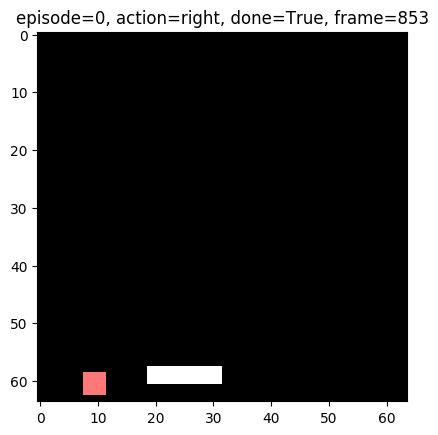

In [9]:
parser = argparse.ArgumentParser(description="A2C Agent")
parser.add_argument("--play", action="store_true",
                    help="play with trained model")
parser.add_argument("--test", action="store_true",
                    help="train by test mode")

args = parser.parse_args(args=["--play"])
main(args.play, args.test)